In [1]:
from io import BytesIO
import os
import os.path
import tarfile
import tempfile

from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from six.moves import urllib
import tensorflow as tf

C:\Users\Admin\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Admin\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Admin\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Admin\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\f

## Import helper methods
These methods help us perform the following tasks:
* Load the latest version of the pretrained DeepLab model
* Load the colormap from the PASCAL VOC dataset
* Adds colors to various labels, such as "pink" for people, "green" for bicycle and more
* Visualize an image, and add an overlay of colors on various regions

In [21]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    INPUT_TENSOR_NAME = "ImageTensor:0"
    OUTPUT_TENSOR_NAME = "SemanticPredictions:0"
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = "frozen_inference_graph"

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()

        if graph_def is None:
            raise RuntimeError("Cannot find inference graph in tar archive.")

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name="")

        self.sess = tf.Session(graph=self.graph)

    def run(self, image):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert("RGB").resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]},
        )
        seg_map = batch_seg_map[0]
        return resized_image, seg_map


def create_pascal_label_colormap():
    """Creates a label colormap used in PASCAL VOC segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError("Expect 2-D input label")

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError("label value too large.")

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis("off")
    plt.title("input image")

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis("off")
    plt.title("segmentation map")

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis("off")
    plt.title("segmentation overlay")

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
        FULL_COLOR_MAP[unique_labels].astype(np.uint8),
        interpolation="nearest",
    )
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid("off")
    plt.show()

LABEL_NAMES = np.asarray([
    "others", "wall", "building", "sky", "floor", "tree", "ceiling", "road",
    "bed", "windowpane", "grass", "cabinet", "sidewalk", "person", "earth",
    "door", "table", "mountain", "plant", "curtain", "chair", "car", "water",
    "painting", "sofa", "shelf", "house", "sea", "mirror", "rug", "field",
    "armchair", "seat", "fence", "desk", "rock", "wardrobe", "lamp", "bathtub",
    "railing", "cushion", "base", "box", "column", "signboard", "chest",
    "counter", "sand", "sink", "skyscraper", "fireplace", "refrigerator",
    "grandstand", "path", "stairs", "runway", "case", "pool", "pillow",
    "screen", "stairway", "river", "bridge", "bookcase", "blind", "coffee",
    "toilet", "flower", "book", "hill", "bench", "countertop", "stove", "palm",
    "kitchen", "computer", "swivel", "boat", "bar", "arcade", "hovel", "bus",
    "towel", "light", "truck", "tower", "chandelier", "awning", "streetlight",
    "booth", "television", "airplane", "dirt", "apparel", "pole", "land",
    "bannister", "escalator", "ottoman", "bottle", "buffet", "poster", "stage",
    "van", "ship", "fountain", "conveyer", "canopy", "washer", "plaything",
    "swimming", "stool", "barrel", "basket", "waterfall", "tent", "bag",
    "minibike", "cradle", "oven", "ball", "food", "step", "tank", "trade",
    "microwave", "pot", "animal", "bicycle", "lake", "dishwasher", "screen",
    "blanket", "sculpture", "hood", "sconce", "vase", "traffic", "tray",
    "ashcan", "fan", "pier", "crt", "plate", "monitor", "bulletin", "shower",
    "radiator", "glass", "clock", "flag"
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

## Select a pretrained model
We have trained the DeepLab model using various backbone networks. Select one from the MODEL_NAME list.

In [3]:
# mobilenetv2_coco_voctrainaug
# mobilenetv2_coco_voctrainval
# xception_coco_voctrainaug
# xception_coco_voctrainval
MODEL_NAME = "mobilenetv2_ade20k_train"

_DOWNLOAD_URL_PREFIX = "http://download.tensorflow.org/models/"
_MODEL_URLS = {
    "mobilenetv2_coco_voctrainaug":
        "deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz",
    "mobilenetv2_coco_voctrainval":
        "deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz",
    "xception_coco_voctrainaug":
        "deeplabv3_pascal_train_aug_2018_01_04.tar.gz",
    "xception_coco_voctrainval":
        "deeplabv3_pascal_trainval_2018_01_04.tar.gz",
    "mobilenetv2_coco_cityscapes_trainfine":
        "deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz",
    "mobilenetv2_ade20k_train":
        "deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz"
}
_TARBALL_NAME = "deeplab_model.tar.gz"

# Root directory of the project
ROOT_DIR = os.path.abspath("..")
MODEL_DIR = os.path.join(ROOT_DIR, "weights")

download_path = os.path.join(MODEL_DIR, _TARBALL_NAME)
if not os.path.exists(download_path):
    print("downloading model, this might take a while...")
    urllib.request.urlretrieve(
        _DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path
    )
    print("download completed! loading DeepLab model...")

MODEL = DeepLabModel(download_path)
print("model loaded successfully!")

model loaded successfully!


## Run on sample images

Select one of sample images (leave `IMAGE_URL` empty) or feed any internet image
url for inference.

Note that this colab uses single scale inference for fast computation,
so the results may slightly differ from the visualizations in the
[README](https://github.com/tensorflow/models/blob/master/research/deeplab/README.md) file,
which uses multi-scale and left-right flipped inputs.

running deeplab on image https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/image1.jpg?raw=true...


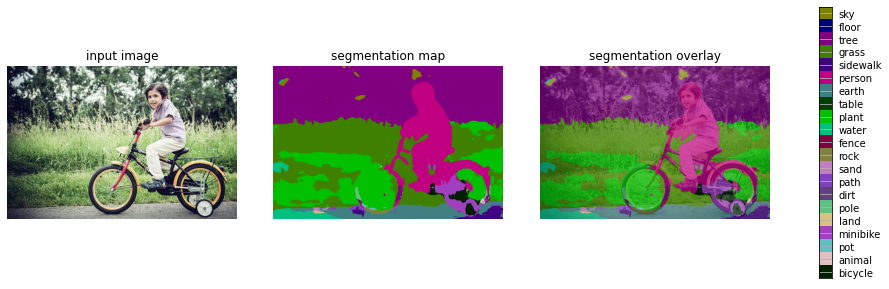

In [22]:
SAMPLE_IMAGE = "image1"  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ""  #@param {type:"string"}

_SAMPLE_URL = (
    "https://github.com/tensorflow/models/blob/master/research/"
    "deeplab/g3doc/img/%s.jpg?raw=true"
)


def run_visualization(url):
    """Inferences DeepLab model and visualizes result."""
    try:
        f = urllib.request.urlopen(url)
        jpeg_str = f.read()
        original_im = Image.open(BytesIO(jpeg_str))
    except IOError:
        print(f"Cannot retrieve image. Please check url: {url}")
        return

    print(f"running deeplab on image {url}...")
    resized_im, seg_map = MODEL.run(original_im)

    vis_segmentation(resized_im, seg_map)


image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

In [7]:
import cv2

In [8]:
VIDEO_PATH = os.path.join(ROOT_DIR, "videos", "People_sample_2.mp4")

In [9]:
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
output_path = f"{os.path.splitext(VIDEO_PATH)[0]}_deeplab.avi"

In [10]:
vid_writer = cv2.VideoWriter(
    output_path,
    cv2.VideoWriter_fourcc("M", "J", "P", "G"),
    fps,
    (
        round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
    ),
)

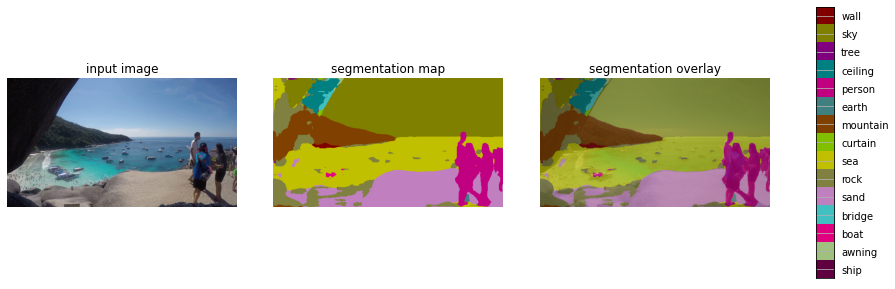

In [23]:
has_frame, frame = cap.read()
resized_im, seg_map = MODEL.run(Image.fromarray(frame[:, :, ::-1]))

vis_segmentation(resized_im, seg_map)
